In [6]:
'''
Goal: seperate the physical datatset, then create the change graphs for cntx and generic weeks

'''
import pandas as pd

# --- Load and clean ---
df = pd.read_csv("feat_dataset_filtered_with_weeks.csv")
df.columns = df.columns.str.replace(' ', '_')

# --- Define your activity columns ---
activity_cols = [
    'loc_workout_dur',
    # on bike
    'act_on_bike_ep_0', 'act_on_bike_ep_1', 'act_on_bike_ep_2', 'act_on_bike_ep_3', 'act_on_bike_ep_4',
    # on foot
    'act_on_foot_ep_0', 'act_on_foot_ep_1', 'act_on_foot_ep_2', 'act_on_foot_ep_3', 'act_on_foot_ep_4',
    # walking
    'act_walking_ep_0', 'act_walking_ep_1', 'act_walking_ep_2', 'act_walking_ep_3', 'act_walking_ep_4',
    # running
    'act_running_ep_0', 'act_running_ep_1', 'act_running_ep_2', 'act_running_ep_3', 'act_running_ep_4'
]

# --- Keep only columns that exist ---
activity_cols = [c for c in activity_cols if c in df.columns]


# --- Compute per-participant averages for Week 1 and Week 6 ---
per_uid_week = (
    df[df['week_per_uid'].isin([1, 6,7,8])]
    .groupby(['uid', 'week_per_uid'])[activity_cols]
    .mean(numeric_only=True)
    .reset_index()
)

print(per_uid_week)
per_uid_week.to_csv("avg_physical_data_week.csv")

               uid  week_per_uid  loc_workout_dur  act_on_bike_ep_0  \
0   t0002@sreflect             1              0.0          8.857143   
1   t0002@sreflect             6              0.0         38.571429   
2   t0002@sreflect             7              0.0          0.000000   
3   t0002@sreflect             8              0.0          0.000000   
4   t0003@sreflect             1              0.0         28.285714   
..             ...           ...              ...               ...   
63  t0019@sreflect             6              0.0       1026.000000   
64  t0020@sreflect             1              0.0         23.857143   
65  t0020@sreflect             6              0.0         64.833333   
66  t0022@sreflect             1              0.0       1231.142857   
67  t0022@sreflect             6              0.0       1022.400000   

    act_on_bike_ep_1  act_on_bike_ep_2  act_on_bike_ep_3  act_on_bike_ep_4  \
0           0.000000          0.000000          0.000000          8.8

/var/folders/r1/_8ps3x2x6nb6r77rz8dp80sh0000gn/T/ipykernel_13855/1536380315.py:8: DtypeWarning: Columns (427) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("feat_dataset_filtered_with_weeks.csv")


In [11]:
'''
we have the mean of each features value for week 1, 6,7,8 now, now we have to compute the change
then use the 'change' value in the graphs to compare cntx vs generic week

change_cntx : this will compute the chnage of features of week 1 and week 6
change_generic: this will compute the change of features of week 7 and week 8

if there's no vale to compute change then put value 0 
'''

import pandas as pd

per_uid_week = pd.read_csv("avg_physical_data_week.csv")

activity_cols = [
    'loc_workout_dur',
    'act_on_bike_ep_0','act_on_bike_ep_1','act_on_bike_ep_2','act_on_bike_ep_3','act_on_bike_ep_4',
    'act_on_foot_ep_0','act_on_foot_ep_1','act_on_foot_ep_2','act_on_foot_ep_3','act_on_foot_ep_4',
    'act_walking_ep_0','act_walking_ep_1','act_walking_ep_2','act_walking_ep_3','act_walking_ep_4',
    'act_running_ep_0','act_running_ep_1','act_running_ep_2','act_running_ep_3','act_running_ep_4'
]

activity_cols = [c for c in activity_cols if c in per_uid_week.columns]

pivoted = per_uid_week.pivot(
    index="uid",
    columns="week_per_uid",
    values=activity_cols
)

pivoted.columns = [f"{col}_{week}" for col, week in pivoted.columns]
pivoted = pivoted.reset_index()

pct_change = pd.DataFrame()
pct_change["uid"] = pivoted["uid"]

for col in activity_cols:
    w1 = f"{col}_1"
    w6 = f"{col}_6"
    if w1 in pivoted.columns and w6 in pivoted.columns:
        pct_change[f"{col}_pct_change"] = ((pivoted[w6] - pivoted[w1]) / pivoted[w1]) * 100

pct_change.to_csv("physical_activity_percent_change_cntx.csv", index=False)

print("Saved physical_activity_percent_change_cntx.csv")
print(pct_change.head())


Saved physical_activity_percent_change_cntx.csv
              uid  loc_workout_dur_pct_change  act_on_bike_ep_0_pct_change  \
0  t0002@sreflect                         NaN                   335.483871   
1  t0003@sreflect                         NaN                    94.444444   
2  t0004@sreflect                         NaN                          NaN   
3  t0005@sreflect                      -100.0                   209.166667   
4  t0006@sreflect                         NaN                  -100.000000   

   act_on_bike_ep_1_pct_change  act_on_bike_ep_2_pct_change  \
0                          inf                          NaN   
1                          NaN                          NaN   
2                          NaN                          NaN   
3                          NaN                        360.0   
4                          NaN                          NaN   

   act_on_bike_ep_3_pct_change  act_on_bike_ep_4_pct_change  \
0                          NaN           

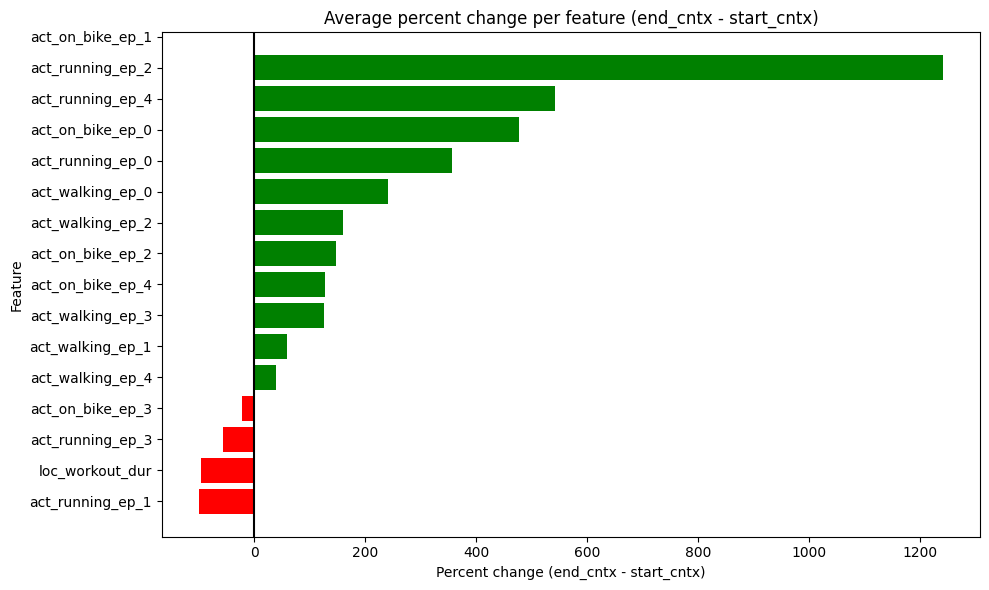

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load percent change file
df = pd.read_csv("physical_activity_percent_change_cntx.csv")

# All percent-change columns (everything except uid)
pct_cols = [c for c in df.columns if c != "uid"]

# Clean up infinities
df[pct_cols] = df[pct_cols].replace([np.inf, -np.inf], np.nan)

# Mean percent change per feature across all users
mean_change = df[pct_cols].mean().sort_values()

# Feature labels without suffix
feature_labels = [c.replace("_pct_change", "") for c in mean_change.index]

# --- Correct graph ---
plt.figure(figsize=(10, 6))
plt.barh(feature_labels, mean_change.values,
         color=["green" if v > 0 else "red" for v in mean_change.values])

plt.axvline(0, color='black')
plt.xlabel("Percent change (end_cntx - start_cntx)")
plt.ylabel("Feature")
plt.title("Average percent change per feature (end_cntx - start_cntx)")
plt.tight_layout()
plt.show()


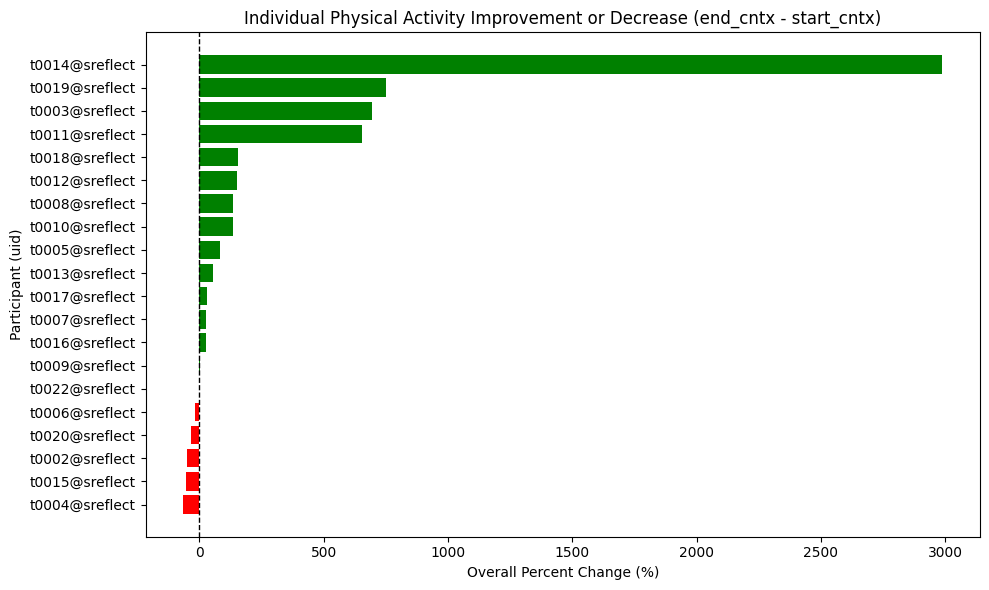

Number of UIDs in data: 20
Number of UIDs in plot: 20


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Load your percent change data ---
df = pd.read_csv("physical_activity_percent_change_cntx.csv")

# Use only the percent-change columns
# (this is safer than "!= uid" in case other cols exist)
pct_cols = [c for c in df.columns if c.endswith("_pct_change")]

# Clean infinities
df[pct_cols] = df[pct_cols].replace([np.inf, -np.inf], np.nan)

# --- Compute each participant's overall (mean) percent change ---
overall = df[pct_cols].mean(axis=1, skipna=True)

# If a participant has all NaNs, set their change to 0
overall = overall.fillna(0)

df["overall_change"] = overall

# --- Sort by change value for better readability ---
df_sorted = df.sort_values("overall_change")

# --- Plot diverging bars per UID ---
plt.figure(figsize=(10, 6))
values = df_sorted["overall_change"]

plt.barh(
    df_sorted["uid"],
    values,
    color=["green" if x > 0 else "red" for x in values]
)

# --- Reference line at 0 (no change) ---
plt.axvline(0, color="black", linestyle="--", linewidth=1)

# --- Labels and styling ---
plt.title("Individual Physical Activity Improvement or Decrease (end_cntx - start_cntx)")
plt.xlabel("Overall Percent Change (%)")
plt.ylabel("Participant (uid)")
plt.tight_layout()

# plt.savefig("individual_activity_improvement_vs_decrease.png", dpi=300)
plt.show()

print("Number of UIDs in data:", df["uid"].nunique())
print("Number of UIDs in plot:", df_sorted["uid"].nunique())


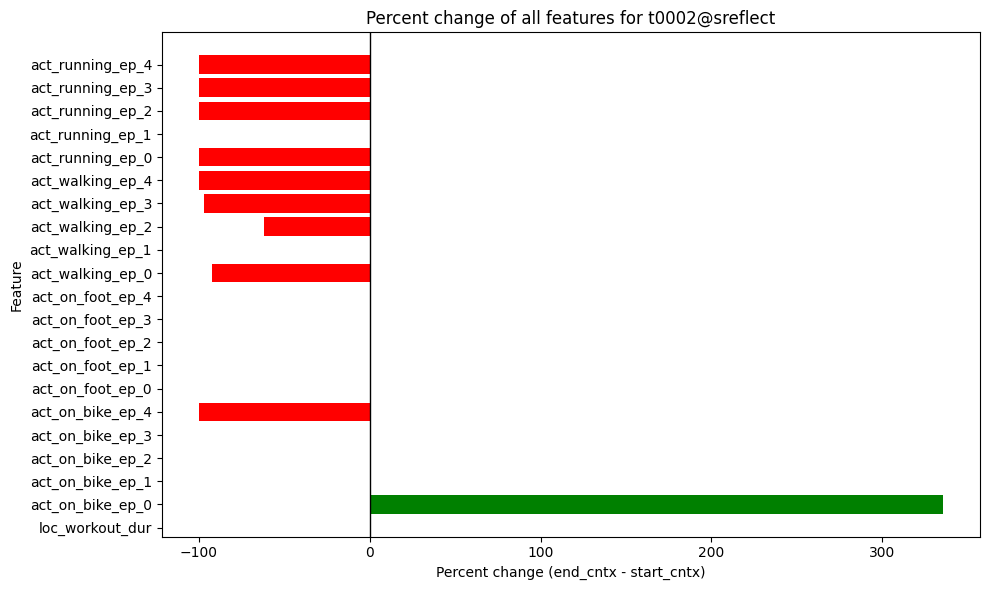

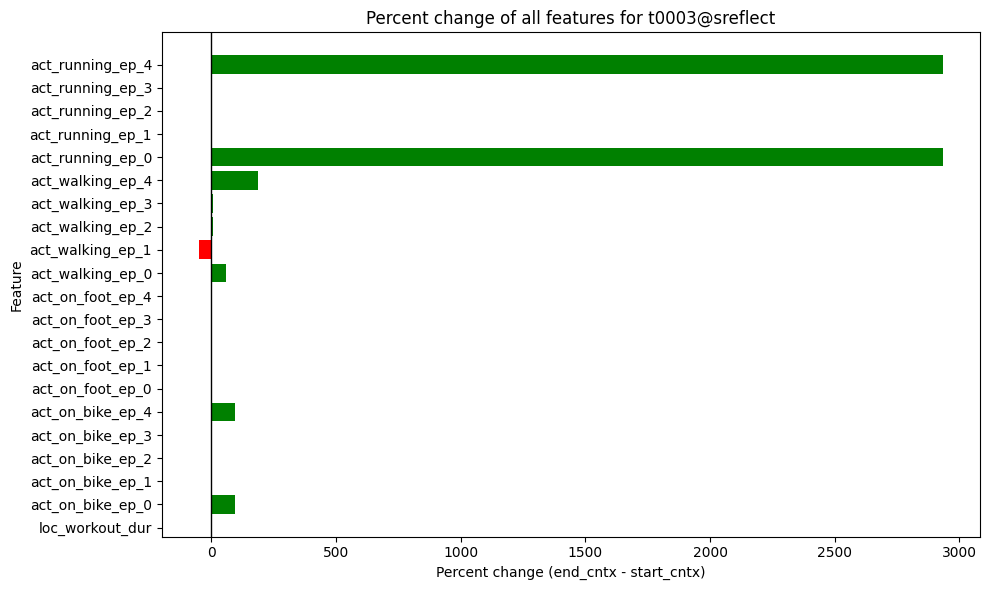

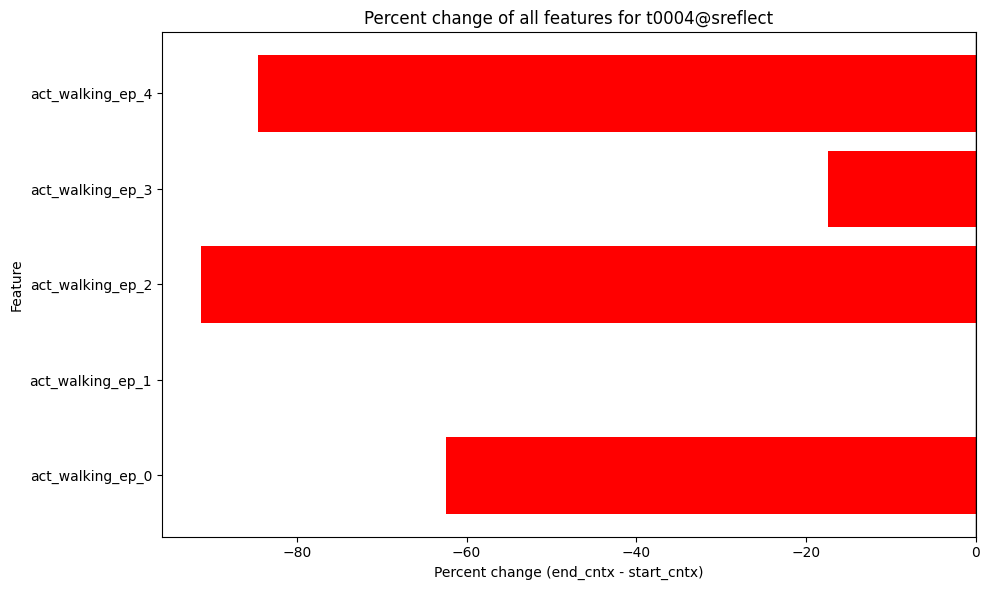

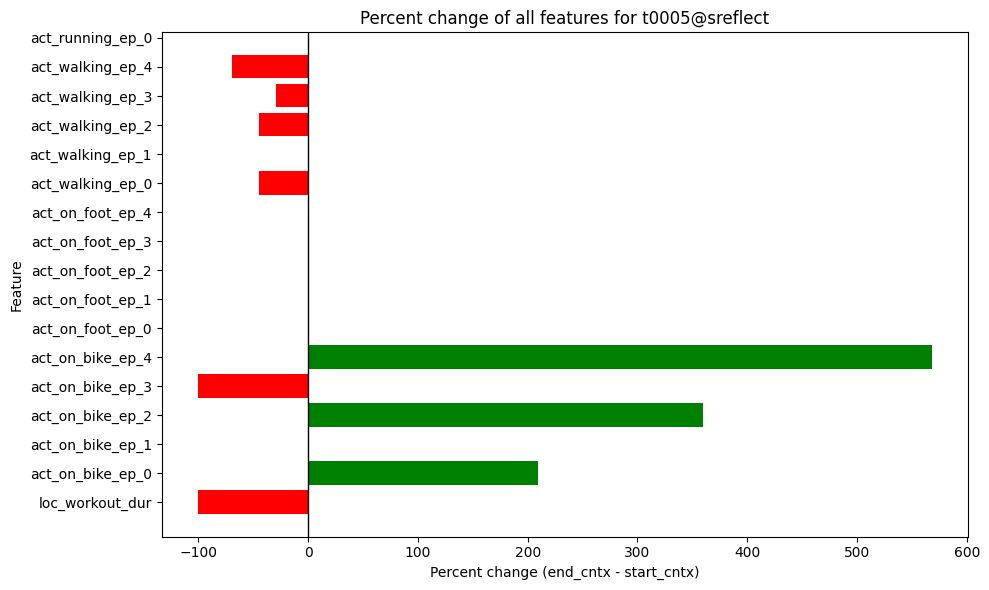

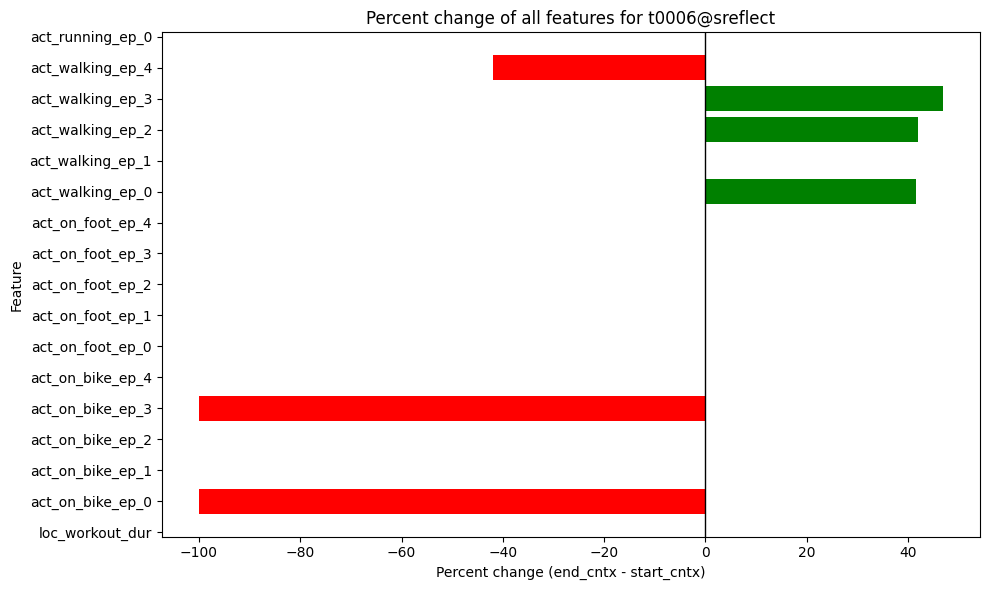

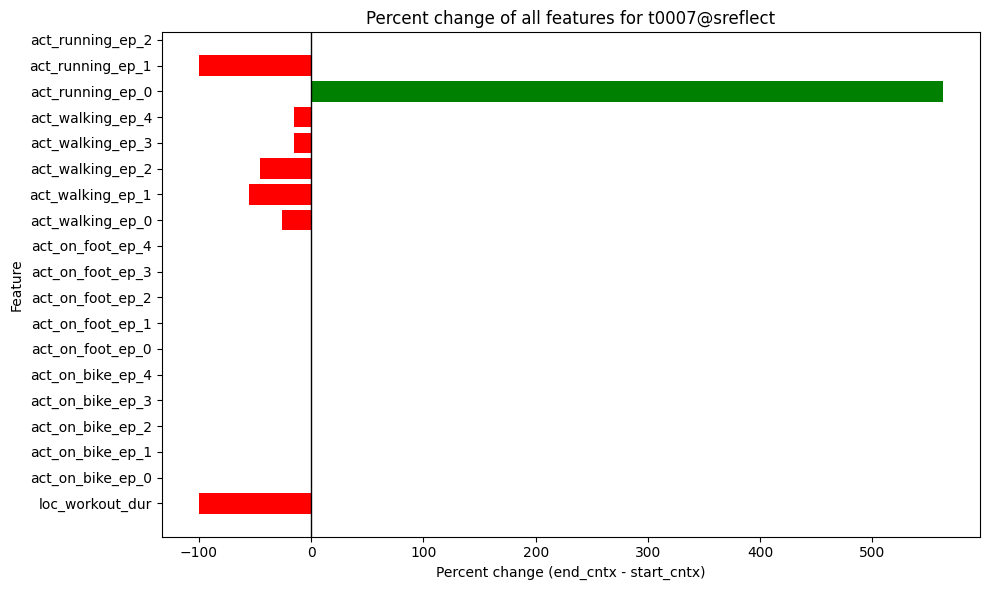

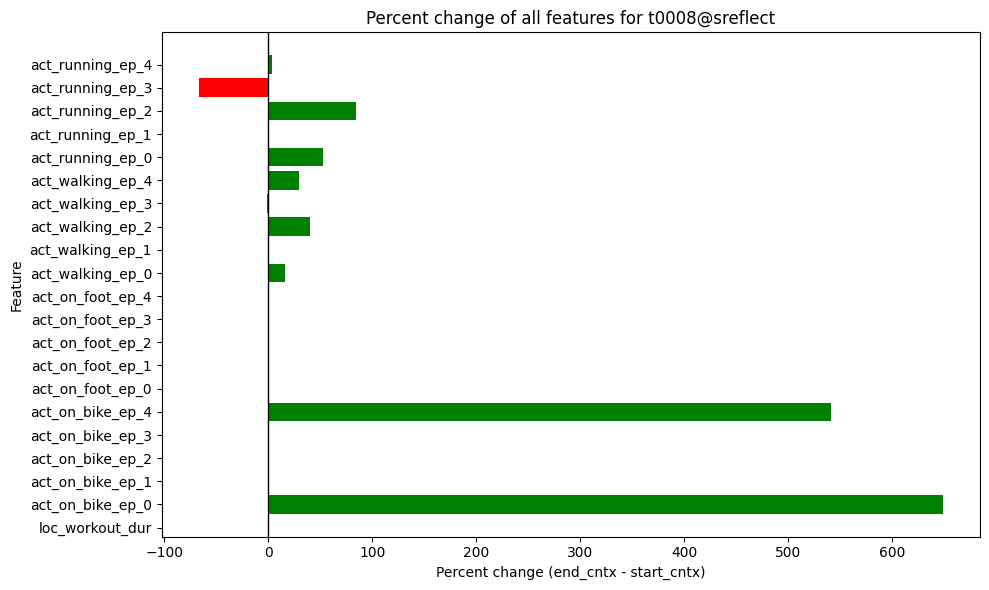

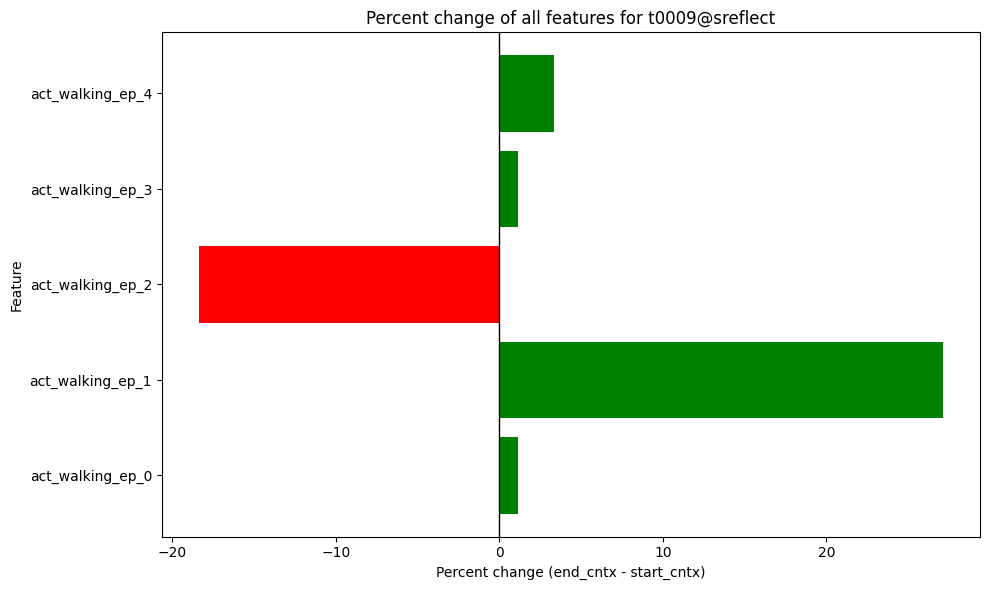

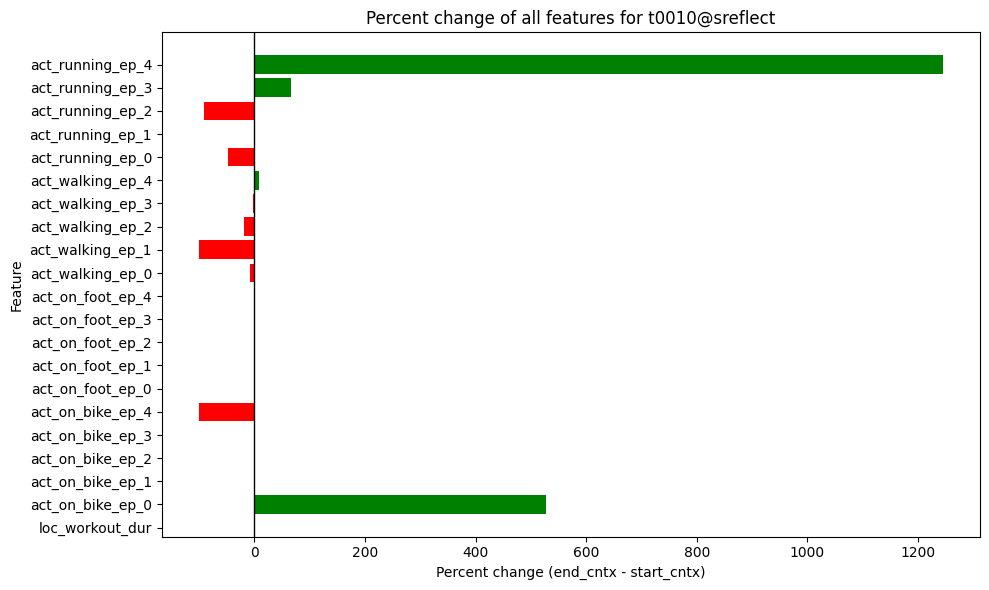

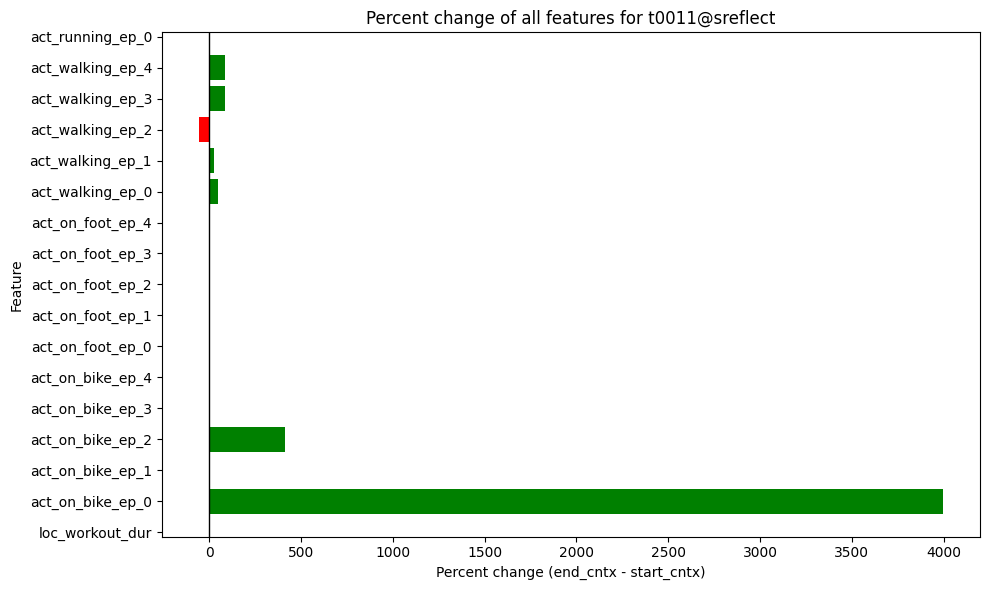

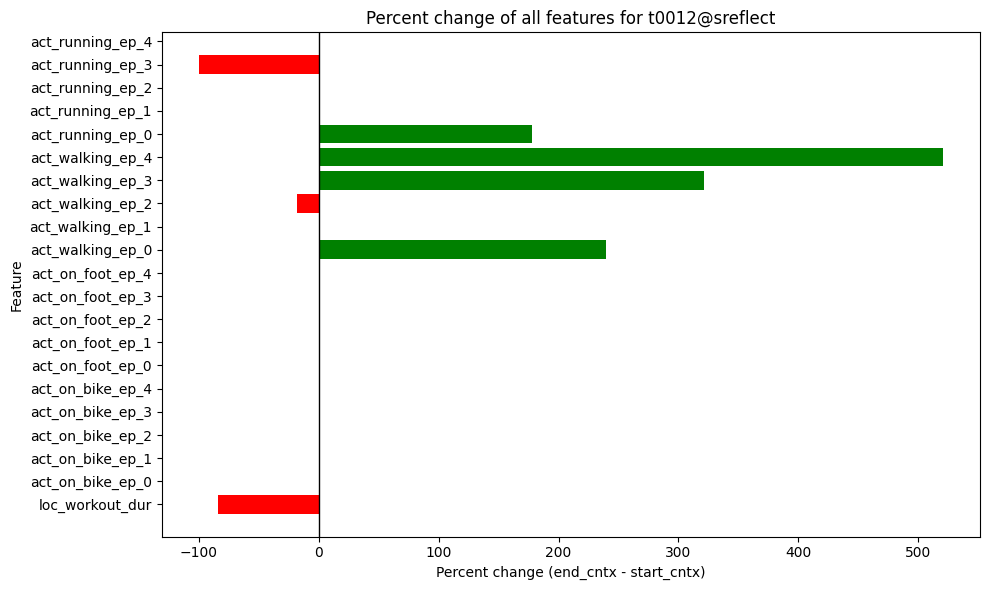

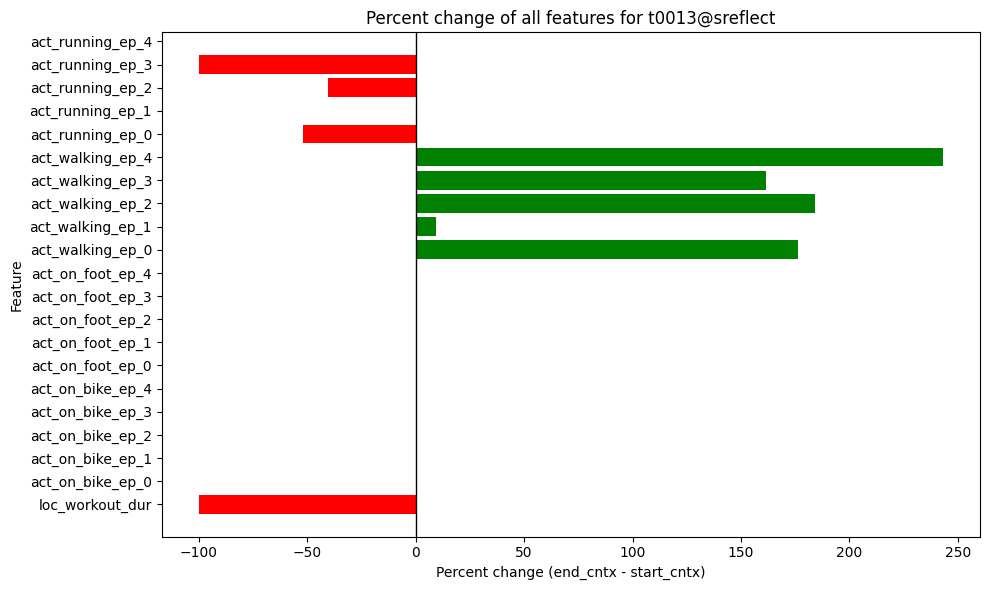

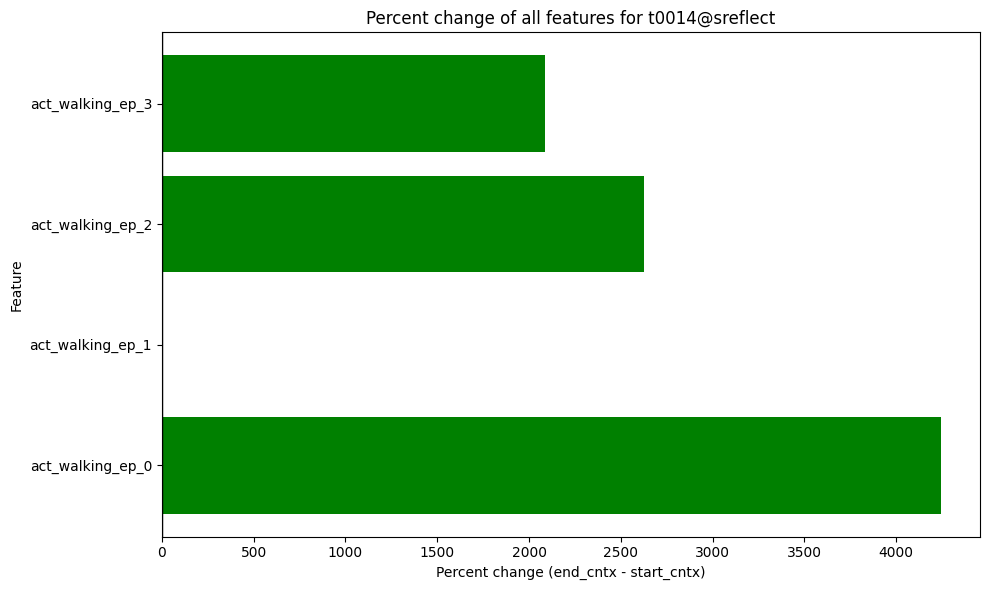

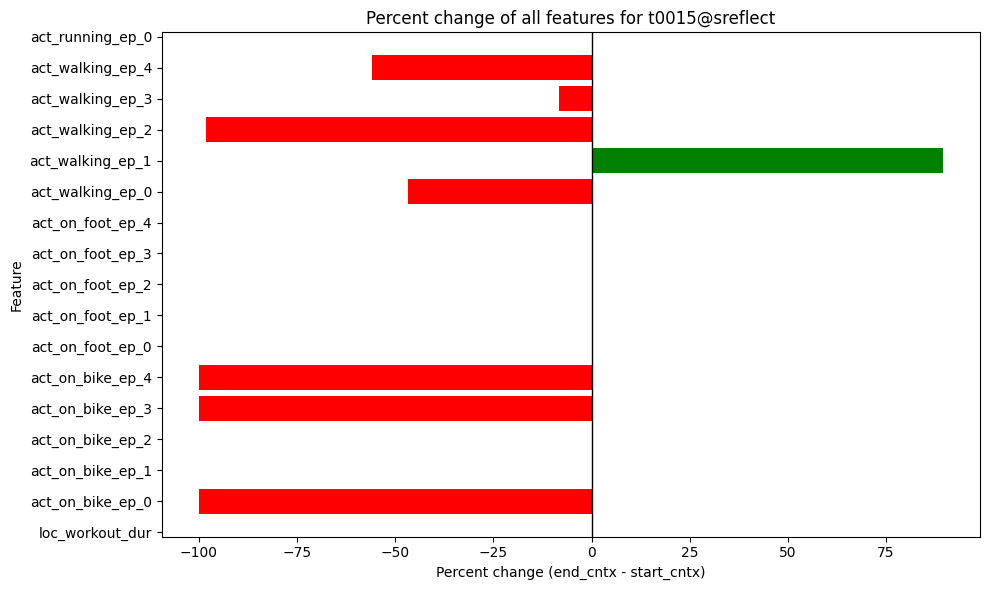

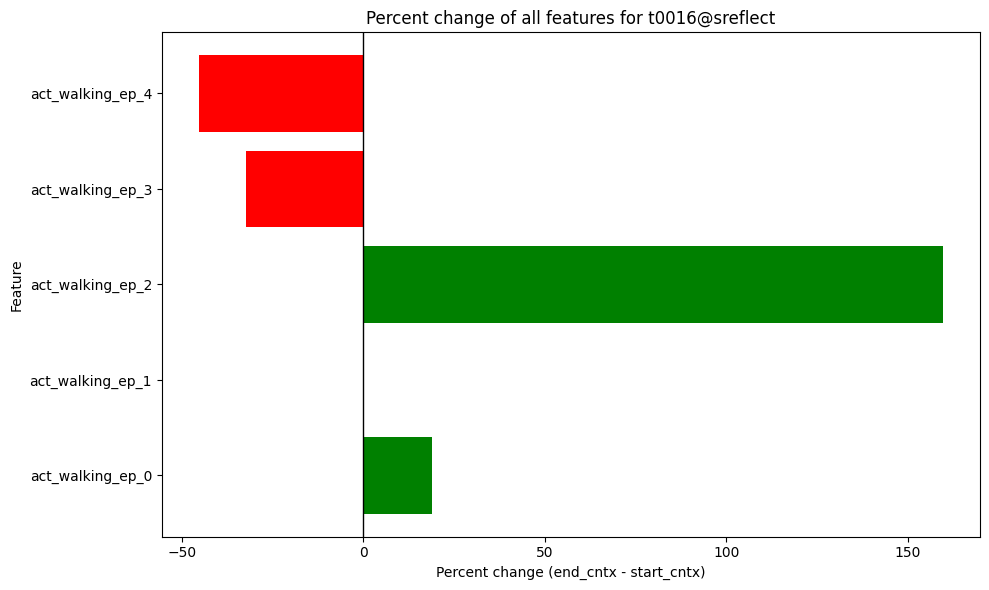

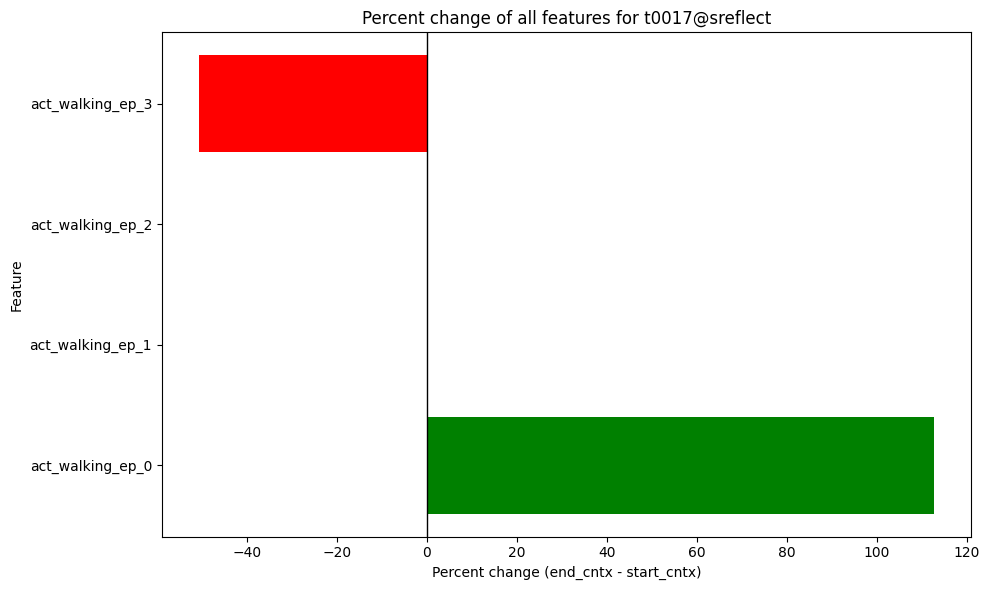

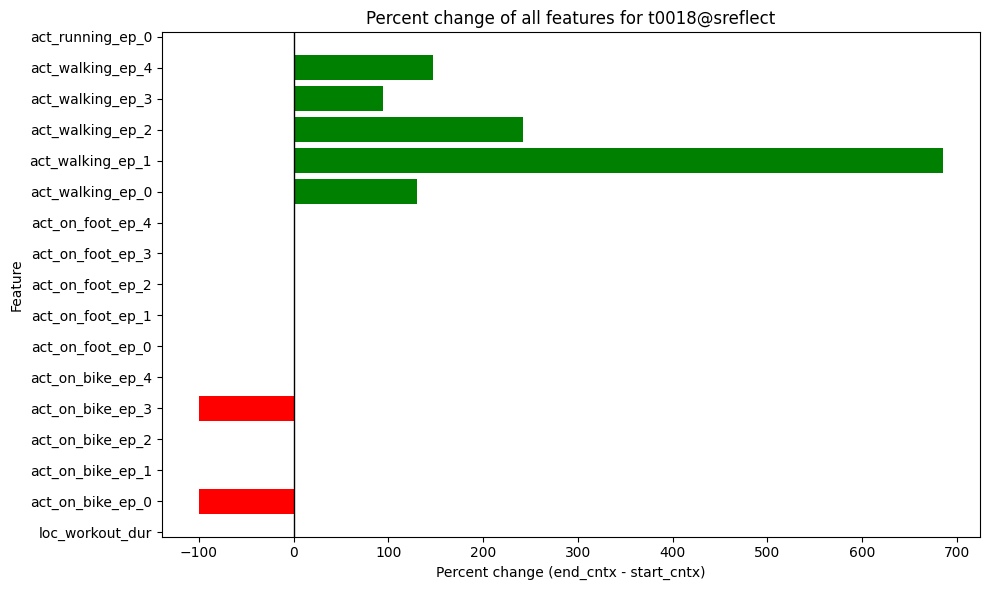

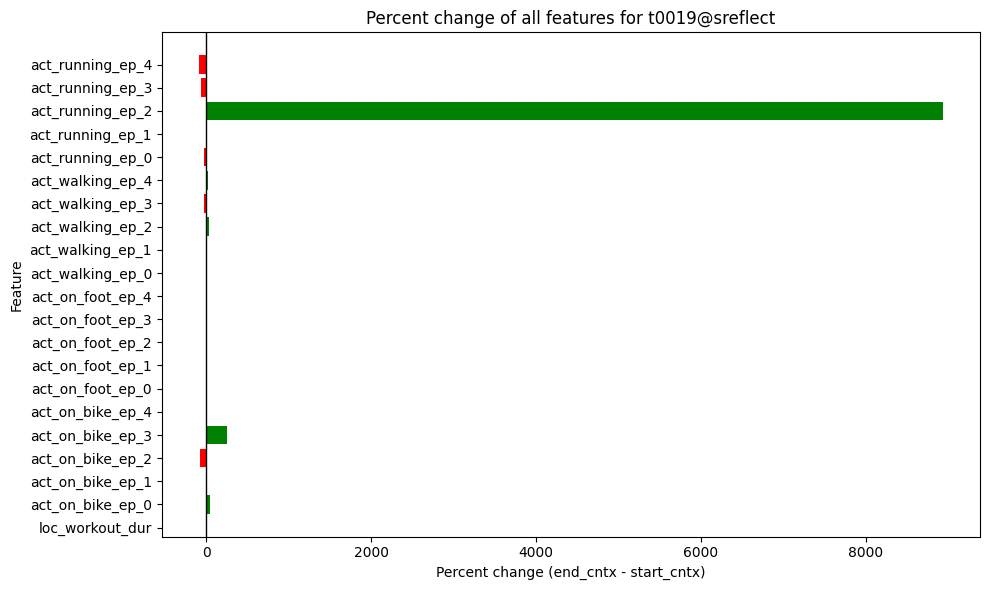

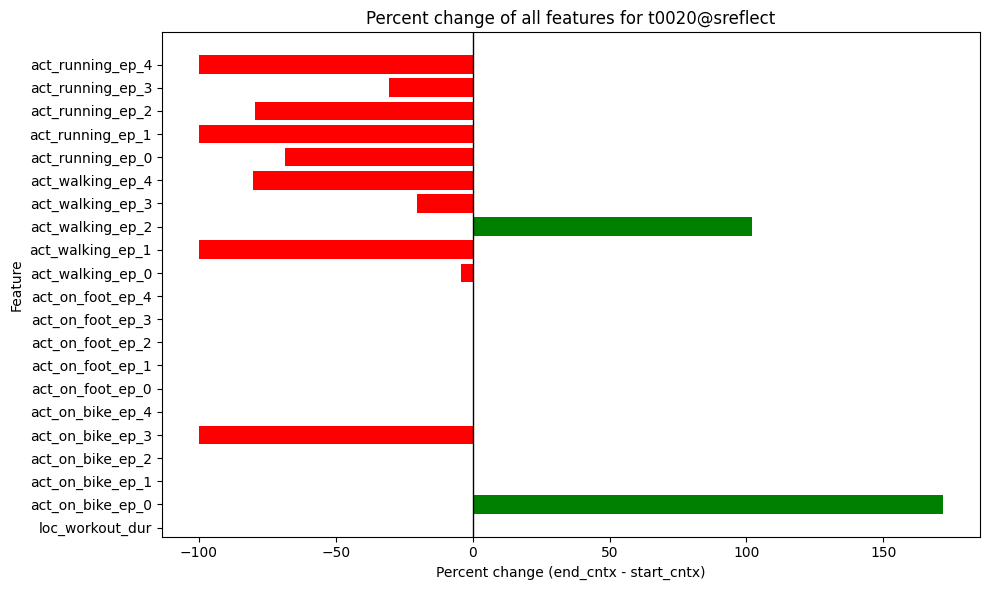

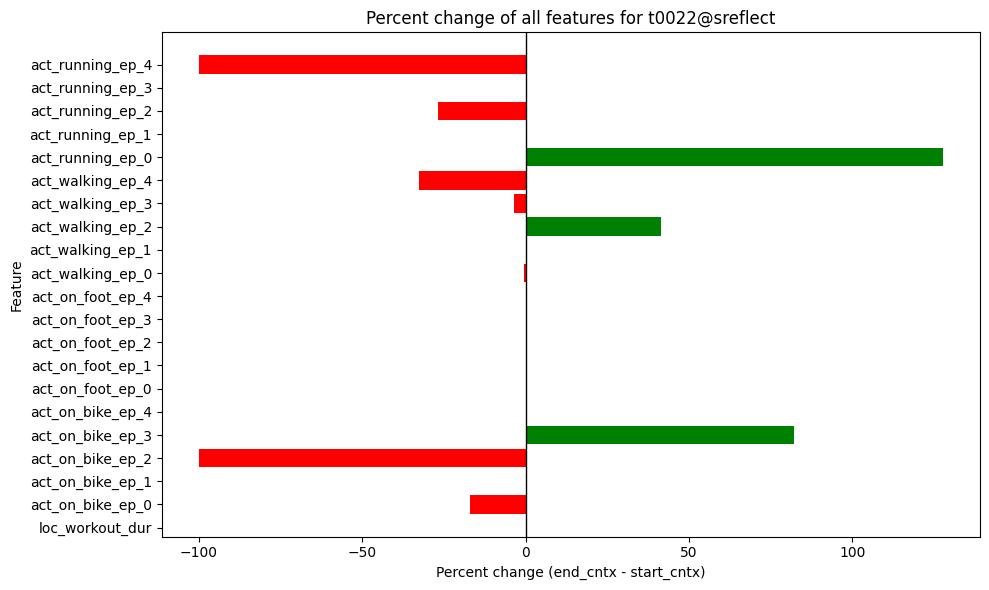

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load data ---
df = pd.read_csv("physical_activity_percent_change_cntx.csv")

# Pick only percent-change columns (all features)
pct_cols = [c for c in df.columns if c.endswith("_pct_change")]

# Clean infinities
df[pct_cols] = df[pct_cols].replace([np.inf, -np.inf], np.nan)

# Loop over each UID and make one graph per person
for uid in df["uid"].unique():
    row = df[df["uid"] == uid]

    # skip if somehow missing
    if row.empty:
        continue

    row = row.iloc[0]

    # feature names and their percent change values
    values = row[pct_cols].values
    labels = [c.replace("_pct_change", "") for c in pct_cols]

    plt.figure(figsize=(10, 6))
    plt.barh(labels, values,
             color=["green" if v > 0 else "red" for v in values])

    plt.axvline(0, color="black", linewidth=1)
    plt.xlabel("Percent change (end_cntx - start_cntx)")
    plt.ylabel("Feature")
    plt.title(f"Percent change of all features for {uid}")
    plt.tight_layout()

    # optional: save each uid’s figure
    # plt.savefig(f"{uid}_all_feature_changes.png", dpi=300)

    plt.show()


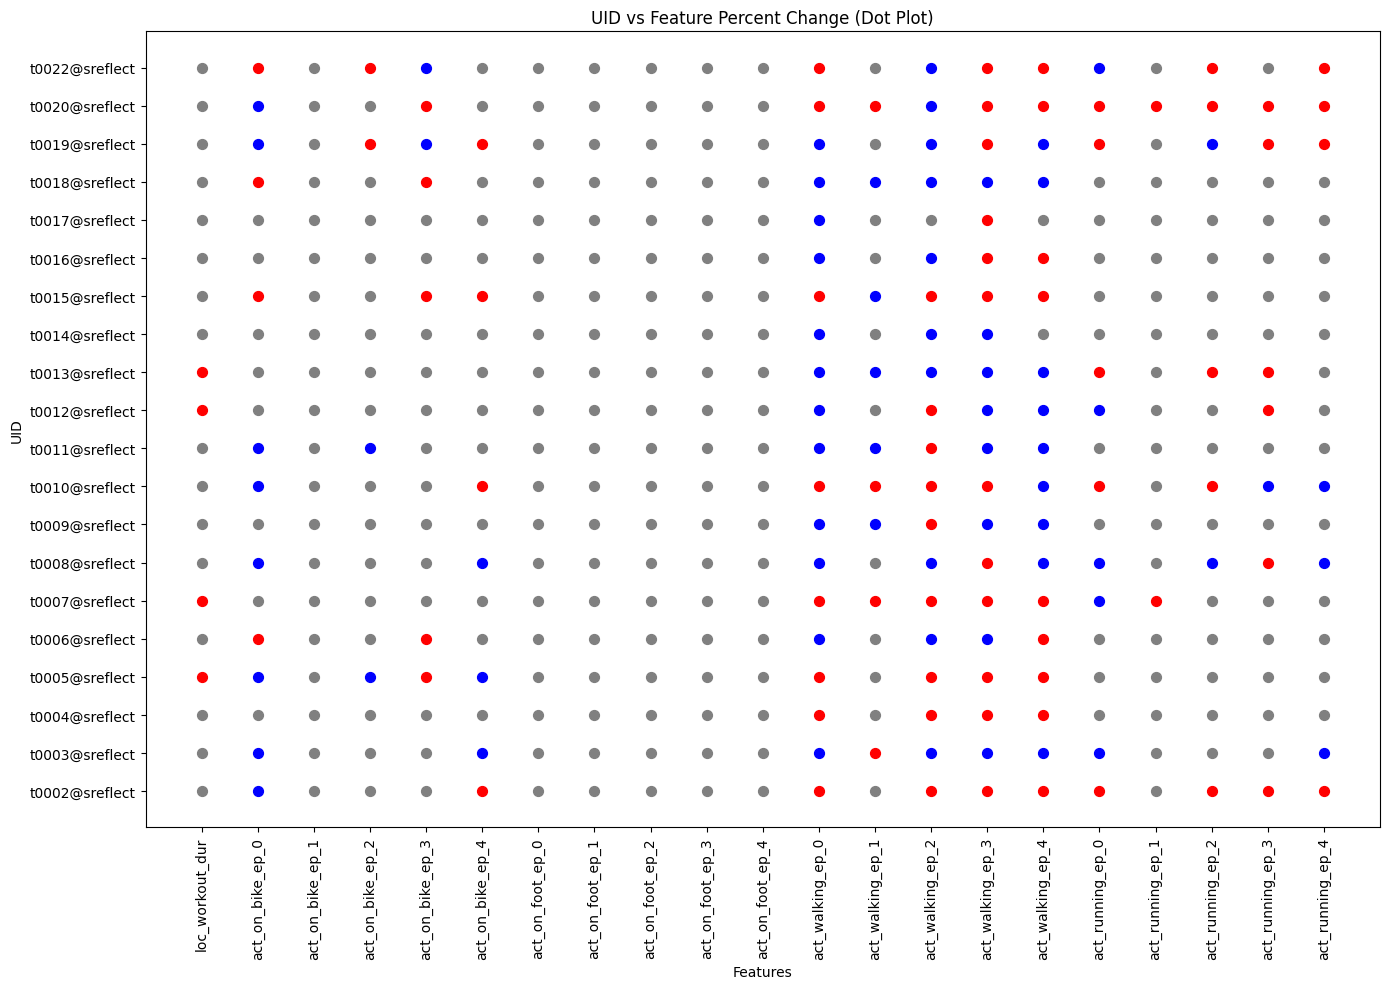

In [30]:
'''

doing a dot graph because in 2d graph won't allow value vs (uid * feature) graph
blue dot meaning increase, red means decresed

'''


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("physical_activity_percent_change_cntx.csv")

pct_cols = [c for c in df.columns if c.endswith("_pct_change")]
df[pct_cols] = df[pct_cols].replace([np.inf, -np.inf], np.nan)

# Format matrix
mat = df.set_index("uid")[pct_cols]
mat.columns = [c.replace("_pct_change", "") for c in mat.columns]

plt.figure(figsize=(14, 10))

# Plot dots
for i, uid in enumerate(mat.index):
    for j, feat in enumerate(mat.columns):
        val = mat.loc[uid, feat]
        plt.scatter(j, i, 
                    s=50,                 # dot size
                    c='blue' if val > 0 else 'red' if val < 0 else 'gray')

plt.xticks(range(len(mat.columns)), mat.columns, rotation=90)
plt.yticks(range(len(mat.index)), mat.index)

plt.title("UID vs Feature Percent Change (Dot Plot)")
plt.xlabel("Features")
plt.ylabel("UID")
plt.tight_layout()
plt.show()


In [32]:

'''
doing for the generic week 

'''

import pandas as pd

per_uid_week = pd.read_csv("avg_physical_data_week.csv")

activity_cols = [
    'loc_workout_dur',
    'act_on_bike_ep_0','act_on_bike_ep_1','act_on_bike_ep_2','act_on_bike_ep_3','act_on_bike_ep_4',
    'act_on_foot_ep_0','act_on_foot_ep_1','act_on_foot_ep_2','act_on_foot_ep_3','act_on_foot_ep_4',
    'act_walking_ep_0','act_walking_ep_1','act_walking_ep_2','act_walking_ep_3','act_walking_ep_4',
    'act_running_ep_0','act_running_ep_1','act_running_ep_2','act_running_ep_3','act_running_ep_4'
]

activity_cols = [c for c in activity_cols if c in per_uid_week.columns]

pivoted = per_uid_week.pivot(
    index="uid",
    columns="week_per_uid",
    values=activity_cols
)

pivoted.columns = [f"{col}_{week}" for col, week in pivoted.columns]
pivoted = pivoted.reset_index()

pct_change = pd.DataFrame()
pct_change["uid"] = pivoted["uid"]

for col in activity_cols:
    w7 = f"{col}_7"
    w8 = f"{col}_8"
    if w1 in pivoted.columns and w6 in pivoted.columns:
        pct_change[f"{col}_pct_change"] = ((pivoted[w8] - pivoted[w7]) / pivoted[w7]) * 100

pct_change.to_csv("physical_activity_percent_change_generic.csv", index=False)

print("Saved physical_activity_percent_change_generic.csv")
print(pct_change.head())


Saved physical_activity_percent_change_generic.csv
              uid  loc_workout_dur_pct_change  act_on_bike_ep_0_pct_change  \
0  t0002@sreflect                         NaN                          NaN   
1  t0003@sreflect                         NaN                   -83.250532   
2  t0004@sreflect                         NaN                          NaN   
3  t0005@sreflect                         NaN                   380.069324   
4  t0006@sreflect                         NaN                  -100.000000   

   act_on_bike_ep_1_pct_change  act_on_bike_ep_2_pct_change  \
0                          NaN                          NaN   
1                          NaN                       -100.0   
2                          NaN                          NaN   
3                          NaN                          inf   
4                          NaN                       -100.0   

   act_on_bike_ep_3_pct_change  act_on_bike_ep_4_pct_change  \
0                          NaN        

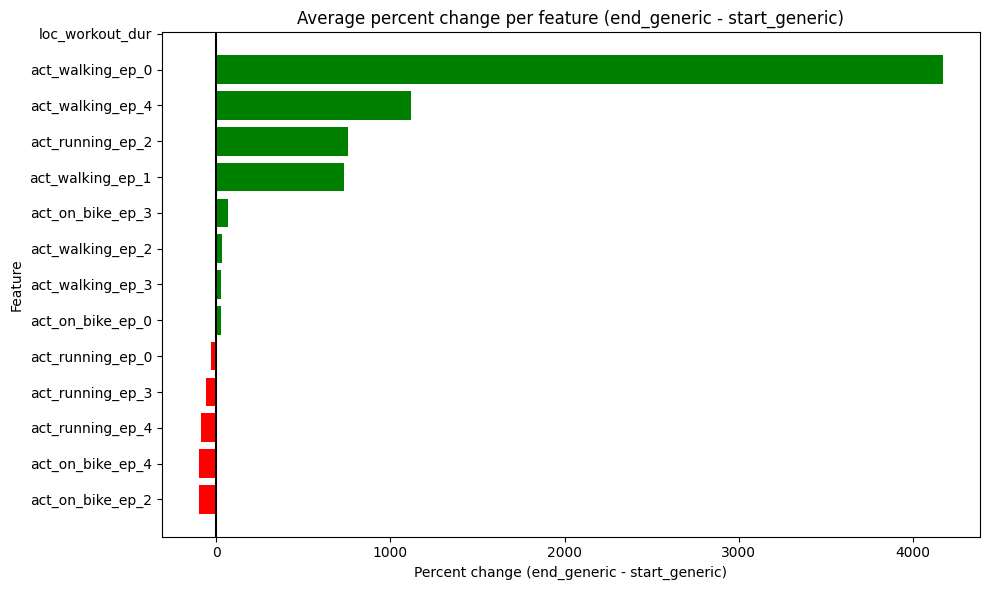

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load percent change file
df = pd.read_csv("physical_activity_percent_change_generic.csv")

# All percent-change columns (everything except uid)
pct_cols = [c for c in df.columns if c != "uid"]

# Clean up infinities
df[pct_cols] = df[pct_cols].replace([np.inf, -np.inf], np.nan)

# Mean percent change per feature across all users
mean_change = df[pct_cols].mean().sort_values()

# Feature labels without suffix
feature_labels = [c.replace("_pct_change", "") for c in mean_change.index]

# --- Correct graph ---
plt.figure(figsize=(10, 6))
plt.barh(feature_labels, mean_change.values,
         color=["green" if v > 0 else "red" for v in mean_change.values])

plt.axvline(0, color='black')
plt.xlabel("Percent change (end_generic - start_generic)")
plt.ylabel("Feature")
plt.title("Average percent change per feature (end_generic - start_generic)")
plt.tight_layout()
plt.show()


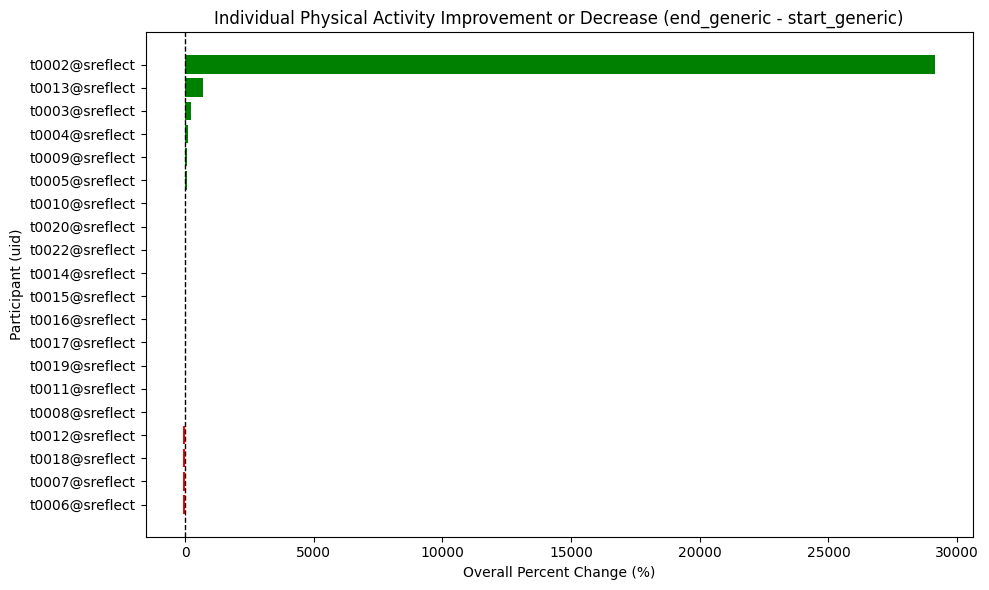

Number of UIDs in data: 20
Number of UIDs in plot: 20


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Load your percent change data ---
df = pd.read_csv("physical_activity_percent_change_generic.csv")

# Use only the percent-change columns
# (this is safer than "!= uid" in case other cols exist)
pct_cols = [c for c in df.columns if c.endswith("_pct_change")]

# Clean infinities
df[pct_cols] = df[pct_cols].replace([np.inf, -np.inf], np.nan)

# --- Compute each participant's overall (mean) percent change ---
overall = df[pct_cols].mean(axis=1, skipna=True)

# If a participant has all NaNs, set their change to 0
overall = overall.fillna(0)

df["overall_change"] = overall

# --- Sort by change value for better readability ---
df_sorted = df.sort_values("overall_change")

# --- Plot diverging bars per UID ---
plt.figure(figsize=(10, 6))
values = df_sorted["overall_change"]

plt.barh(
    df_sorted["uid"],
    values,
    color=["green" if x > 0 else "red" for x in values]
)

# --- Reference line at 0 (no change) ---
plt.axvline(0, color="black", linestyle="--", linewidth=1)

# --- Labels and styling ---
plt.title("Individual Physical Activity Improvement or Decrease (end_generic - start_generic)")
plt.xlabel("Overall Percent Change (%)")
plt.ylabel("Participant (uid)")
plt.tight_layout()

# plt.savefig("individual_activity_improvement_vs_decrease.png", dpi=300)
plt.show()

print("Number of UIDs in data:", df["uid"].nunique())
print("Number of UIDs in plot:", df_sorted["uid"].nunique())


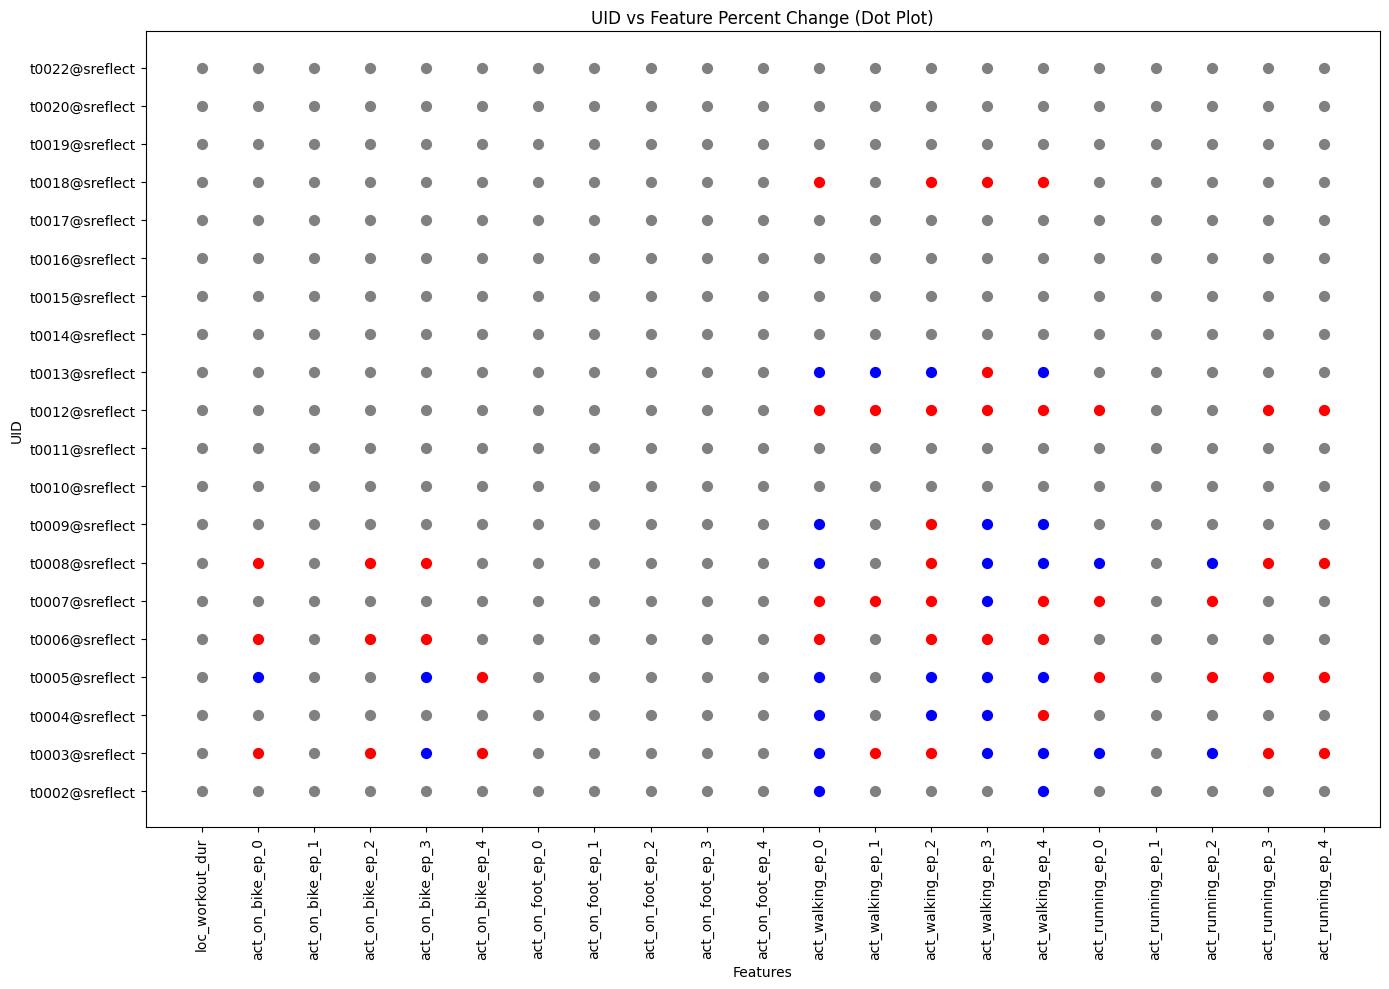

In [35]:
'''

doing a dot graph because in 2d graph won't allow value vs (uid * feature) graph
blue dot meaning increase, red means decresed

'''


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("physical_activity_percent_change_generic.csv")

pct_cols = [c for c in df.columns if c.endswith("_pct_change")]
df[pct_cols] = df[pct_cols].replace([np.inf, -np.inf], np.nan)

# Format matrix
mat = df.set_index("uid")[pct_cols]
mat.columns = [c.replace("_pct_change", "") for c in mat.columns]

plt.figure(figsize=(14, 10))

# Plot dots
for i, uid in enumerate(mat.index):
    for j, feat in enumerate(mat.columns):
        val = mat.loc[uid, feat]
        plt.scatter(j, i, 
                    s=50,                 # dot size
                    c='blue' if val > 0 else 'red' if val < 0 else 'gray')

plt.xticks(range(len(mat.columns)), mat.columns, rotation=90)
plt.yticks(range(len(mat.index)), mat.index)

plt.title("UID vs Feature Percent Change (Dot Plot)")
plt.xlabel("Features")
plt.ylabel("UID")
plt.tight_layout()
plt.show()
